In [2]:
import numpy as np
import pandas as pd # we need pandas to manipulate time series
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

import pastas as ps
import os
import folium

### Continental Climate - South Dakota

The Continental climate can be found a little south of the Canadian border in the East-Central part of the USA, which includes (parts of) states such as South-Dakota, Nebraska, Iowa, Minnesota, Illinois, Indiana and Ohio. The Continental climate is characterized by cold winters and warm summers. The average winter temperatures are around -3 degrees celcius and below, where the summer temperatures are higher than 22 degrees Celcius. Most precipitation falls in the summer months, however there is significant snowfall during the winter months. 

This well is situated near Huron in South-Dakota on a height of 398.64 meters. The well is part of the Warren Aquifer and it is classified as an unconfined aquifer. The water in the well is between 1 and 12 meters below the ground surface. The top 16 meters of the well is comprised of Till, after which 15 meters of sand is found. 

The groundwater data was taken from the USGS website: https://maps.waterdata.usgs.gov/mapper/ \
The Precipitation and Temperature data was taken from the NCEI NOAA website: https://www.ncei.noaa.gov/maps/daily-summaries/ \
Using the Temperature data, the Evaporation was generated with the help of the pyet python package, using the Hargreaves formula. 

In [3]:
map = folium.Map(location=[44.38, -98.30], zoom_start=6)
folium.Marker([44.38, -98.22], popup='Weather Station').add_to(map)
folium.Marker([44.38, -98.30], popup='Well').add_to(map);

In [4]:
map

##### Well South Dakota - Huron - 442254098174501

In [5]:
height = 398.64 # meters above mean sea level

head_import = pd.read_csv('GW_Data/Huron_SD_442254098174501.csv', delimiter=';', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(head_import.index)
head_old = head_import.sort_index()

head = -head_old.subtract(height)  # Water level above MSL

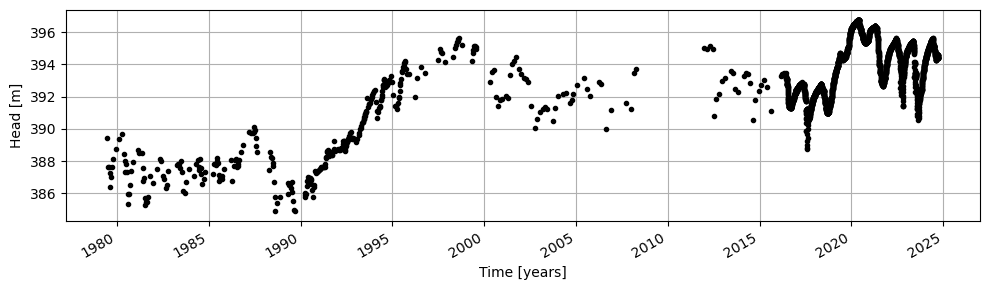

In [6]:
head.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

In [7]:
prec = pd.read_csv('Prec_temp/Huron_3977587.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'PRCP'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(prec.index)
PRCP = prec.sort_index()

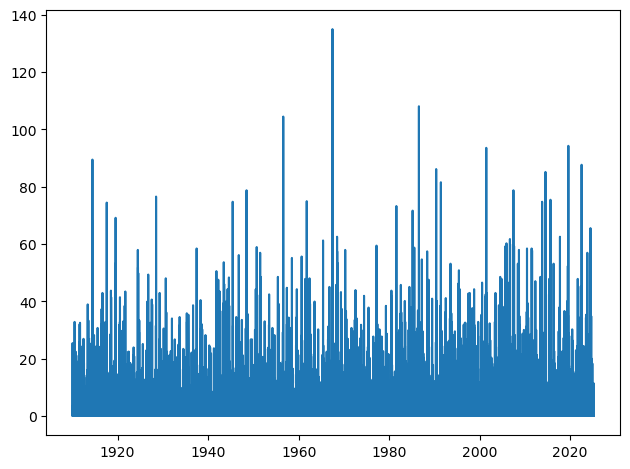

In [8]:
plt.plot(PRCP)

In [9]:
evap = pd.read_csv('Evap/Huron.csv', delimiter=',', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(evap.index)
EPOT = evap.sort_index()

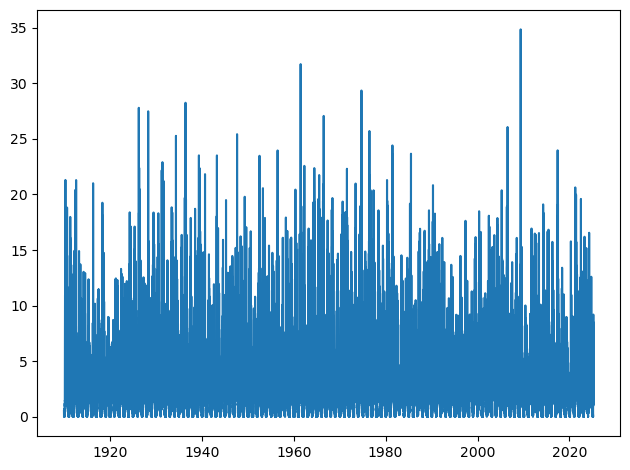

In [10]:
plt.plot(EPOT)

In [11]:
PRCP = PRCP.resample("24h", closed="right", label="right").mean()

In [12]:
EPOT = EPOT.resample("24h", closed="right", label="right").mean()

#### Basic Model

In [13]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    75                     EVP        72.21
nobs    3383                   R2          0.72
noise   False                  RMSE        1.16
tmin    1979-06-26 00:00:00    AICc     1024.00
tmax    2024-09-30 00:00:00    BIC      1054.61
freq    D                      Obj      2282.67
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (5 optimized)
                optimal     initial  vary
rch_A         16.959259    0.169597  True
rch_n          1.070854    1.000000  True
rch_a       2443.613068   10.000000  True
rch_f         -0.842301   -1.000000  True
constant_d   410.715669  393.412261  True

Warnings! (1)
Response tmax for 'rch' > than calibration period.


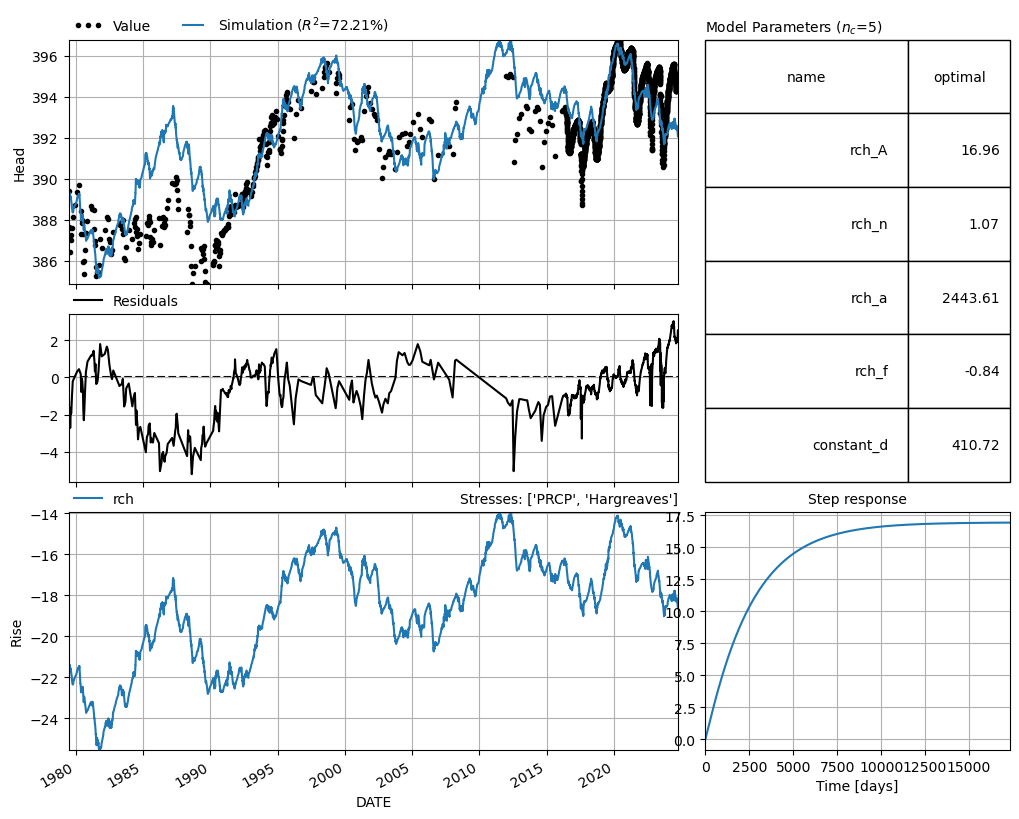

In [14]:
ml.plots.results();

#### Resampled Monthly

In [15]:
head_resampled = head.resample('M').last()

In [16]:
head_resampled

Date and Time
1979-06-30    389.404560
1979-07-31    387.606240
1979-08-31    387.240480
1979-09-30    387.606240
1979-10-31    388.154880
                 ...    
2024-05-31    395.555424
2024-06-30    395.113464
2024-07-31    394.567872
2024-08-31    394.503864
2024-09-30    394.595304
Freq: M, Name: Value, Length: 544, dtype: float64

In [17]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 206 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    66                     EVP       77.93
nobs    338                    R2         0.78
noise   False                  RMSE       1.43
tmin    1979-06-30 00:00:00    AICc     251.87
tmax    2024-09-30 00:00:00    BIC      270.80
freq    D                      Obj      345.48
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (5 optimized)
                optimal     initial  vary
rch_A         16.959722    0.169597  True
rch_n          1.046943    1.000000  True
rch_a       3285.446729   10.000000  True
rch_f         -0.513085   -1.000000  True
constant_d   393.178287  391.283309  True

Warnings! (2)
Parameter 'rch_A' on upper bound: 1.70e+01
Response tmax for 'rch' > than calibration period.


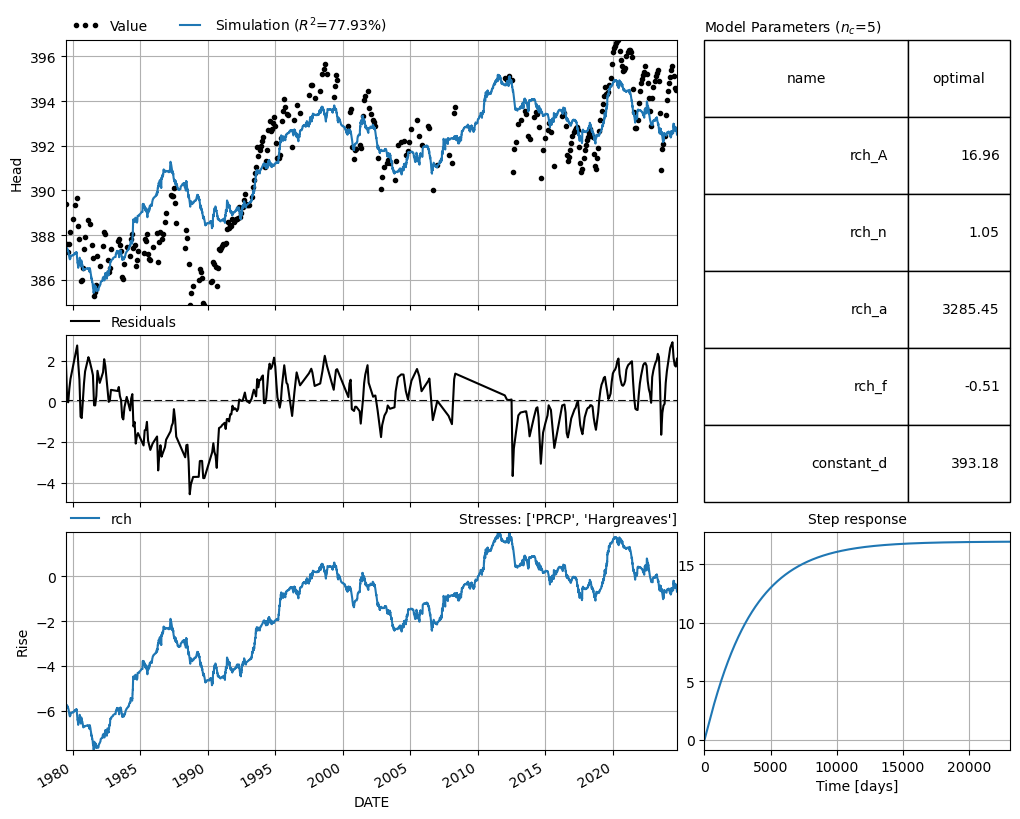

In [18]:
ml.plots.results();

### Non-Linear Recharge model & different response functions

In [19]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.DoubleExponential(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 206 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    85                     EVP       78.16
nobs    338                    R2         0.78
noise   False                  RMSE       1.42
tmin    1979-06-30 00:00:00    AICc     250.40
tmax    2024-09-30 00:00:00    BIC      273.09
freq    D                      Obj      341.89
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (6 optimized)
                optimal     initial  vary
rch_A         16.959722    0.169597  True
rch_alpha      0.041922    0.100000  True
rch_a1      4506.788806   10.000000  True
rch_a2       353.975203   10.000000  True
rch_f         -0.417212   -1.000000  True
constant_d   388.608374  391.283309  True

Warnings! (2)
Parameter 'rch_A' on upper bound: 1.70e+01
Response tmax for 'rch' > than calibration period.


In [20]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.DoubleExponential(), name="rch", recharge=ps.rch.FlexModel())
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 206 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    99                     EVP       76.13
nobs    338                    R2         0.76
noise   False                  RMSE       1.49
tmin    1979-06-30 00:00:00    AICc     284.61
tmax    2024-09-30 00:00:00    BIC      314.75
freq    D                      Obj      373.64
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (8 optimized)
                optimal     initial   vary
rch_A         48.057545    0.873923   True
rch_alpha      0.935934    0.100000   True
rch_a1       366.789461   10.000000   True
rch_a2      4998.013421   10.000000   True
rch_srmax   1000.000000  250.000000   True
rch_lp         0.250000    0.250000  False
rch_ks       988.485270  100.000000   True
rch_gamma      3.794400    2.000000   True
rch_kv         1.000000    1.000000  False
rch_simax      2.000000    2.000000  False
constant_d   381.971632  391.283309   True

Warnings! (2)
Parameter 'rch_srmax

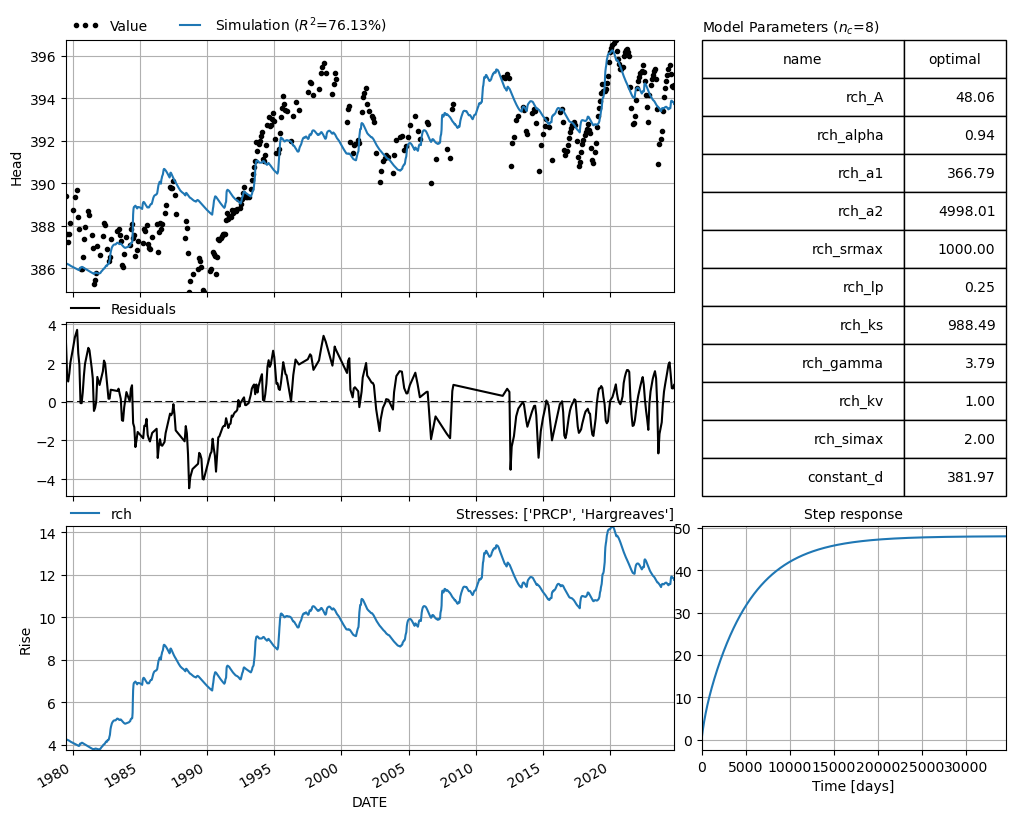

In [40]:
ml.plots.results();

### Add Trend, Snow, groundwater uptake

#### Add a trendline

In [21]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Linear())
ml.add_stressmodel(sm)

tm = ps.LinearTrend(start="1990-01-01", end="1999-01-01", name="trend")
ml.add_stressmodel(tm)

ml.solve()

INFO: Time Series 'Value': 206 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    54                     EVP          86.55
nobs    338                    R2            0.87
noise   False                  RMSE          1.12
tmin    1979-06-30 00:00:00    AICc         86.58
tmax    2024-09-30 00:00:00    BIC         109.27
freq    D                      Obj         210.57
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (6 optimized)
                    optimal        initial   vary
rch_A              1.739223       0.169597   True
rch_n              1.296155       1.000000   True
rch_a            407.547502      10.000000   True
rch_f             -1.504602      -1.000000   True
trend_a            0.001656       0.000000   True
trend_tstart  726468.000000  726468.000000  False
trend_tend    729755.000000  729755.000000  False
constant_d       393.458937     391.283309   True

Warnings! (1)
Response tmax for 'trend' > than calibration period.


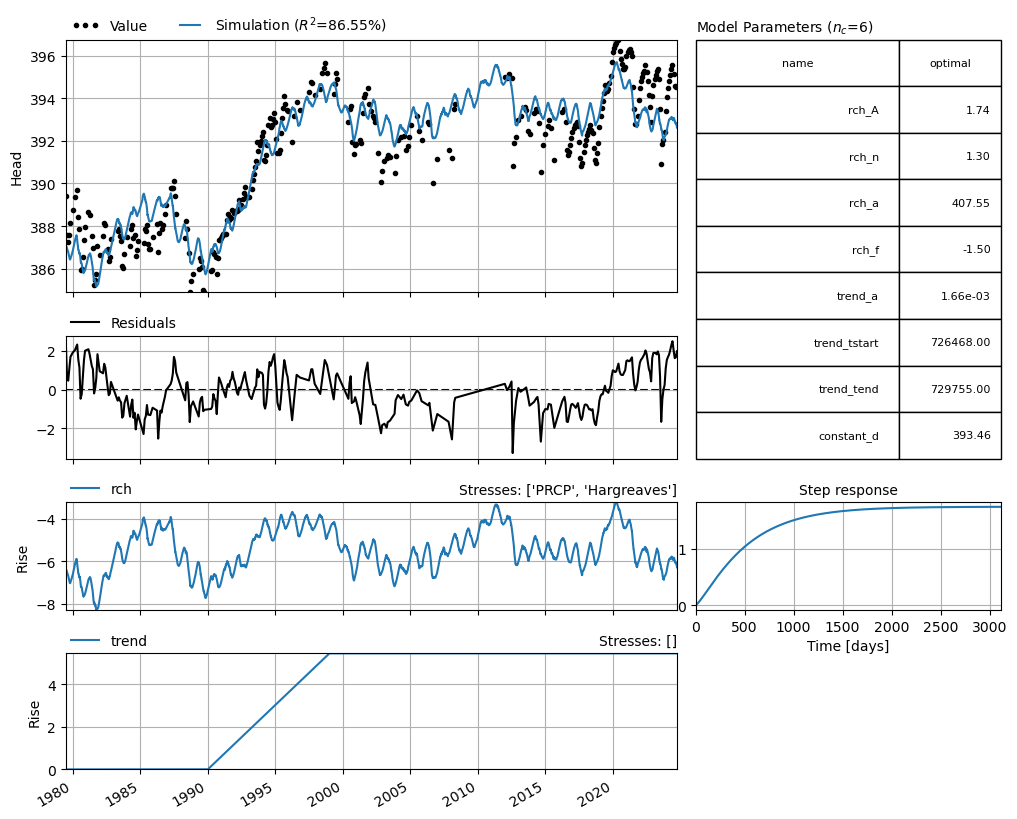

In [22]:
ml.plots.results();

#### Add Snowmodel

In [23]:
temp_max = pd.read_csv('Prec_temp/Huron_3977587.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'TMAX'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(temp_max.index)
TMAX = temp_max.sort_index()

temp_min = pd.read_csv('Prec_temp/Huron_3977587.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'TMIN'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(temp_min.index)
TMIN = temp_min.sort_index()

Temp = (TMAX + TMIN)/2

In [24]:
Temp = Temp.resample("24h", closed="right", label="right").mean()

In [31]:
ml1 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, recharge=ps.rch.FlexModel(snow=True), 
                      rfunc=ps.Gamma(), name="rch", temp=Temp)
ml1.add_stressmodel(sm)

tm = ps.LinearTrend(start="1990-01-01", end="1999-01-01", name="trend")
ml1.add_stressmodel(tm)

ml1.solve()

INFO: Time Series 'Value': 206 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    40                     EVP          83.08
nobs    338                    R2            0.83
noise   False                  RMSE          1.25
tmin    1979-06-30 00:00:00    AICc        172.62
tmax    2024-09-30 00:00:00    BIC         210.18
freq    D                      Obj         264.92
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (10 optimized)
                    optimal        initial   vary
rch_A              3.997057       0.829317   True
rch_n              2.722145       1.000000   True
rch_a            185.764288      10.000000   True
rch_srmax        237.095685     250.000000   True
rch_lp             0.250000       0.250000  False
rch_ks           245.766233     100.000000   True
rch_gamma          0.023836       2.000000   True
rch_kv             1.000000       1.000000  False
rch_simax          2.000000       2.000000  False
rch_tt             2.40

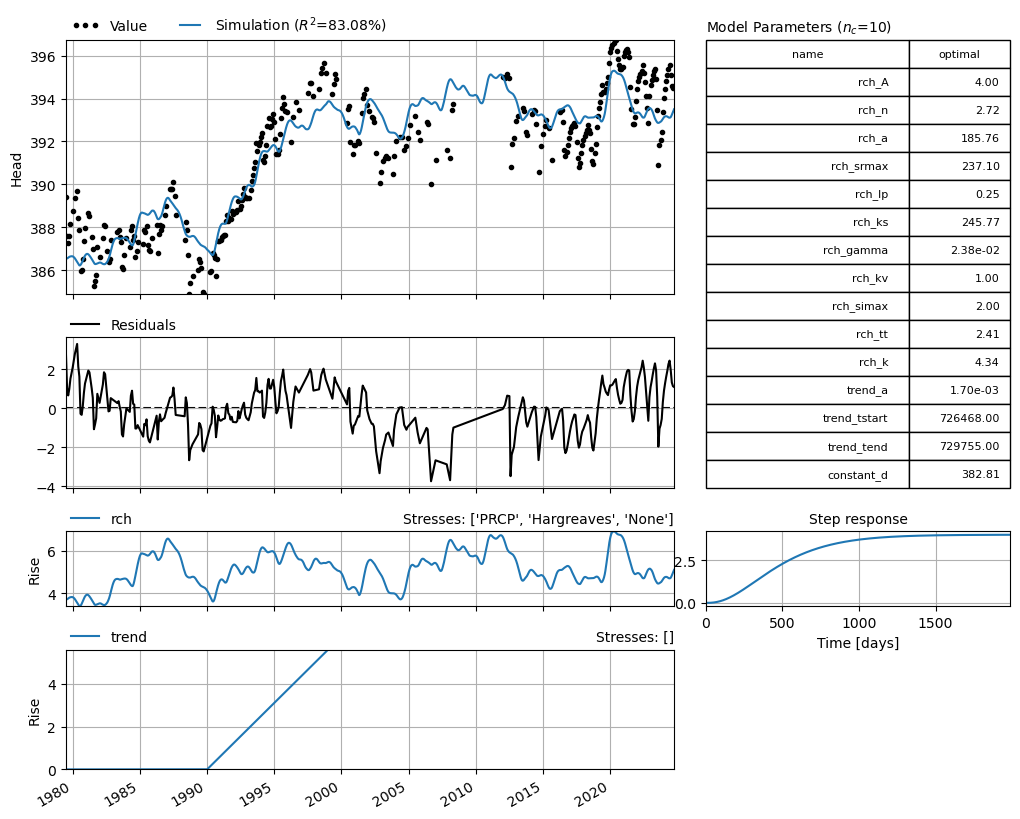

In [32]:
ml1.plots.results();

#### Snow model and Groundwater uptake

In [33]:
ml2 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, recharge=ps.rch.FlexModel(snow=True, gw_uptake=True), 
                      rfunc=ps.Gamma(), name="rch", temp=Temp)
ml2.add_stressmodel(sm)

tm = ps.LinearTrend(start="1990-01-01", end="1999-01-01", name="trend")
ml2.add_stressmodel(tm)

ml2.solve()

INFO: Time Series 'Value': 206 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    92                     EVP          86.23
nobs    338                    R2            0.86
noise   False                  RMSE          1.13
tmin    1979-06-30 00:00:00    AICc        105.03
tmax    2024-09-30 00:00:00    BIC         146.27
freq    D                      Obj         215.54
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (11 optimized)
                    optimal        initial   vary
rch_A              2.176847       0.319859   True
rch_n              1.434946       1.000000   True
rch_a            311.062260      10.000000   True
rch_srmax        161.898415     250.000000   True
rch_lp             0.250000       0.250000  False
rch_ks           121.931278     100.000000   True
rch_gamma          0.843015       2.000000   True
rch_kv             1.000000       1.000000  False
rch_simax          2.000000       2.000000  False
rch_gf             0.89

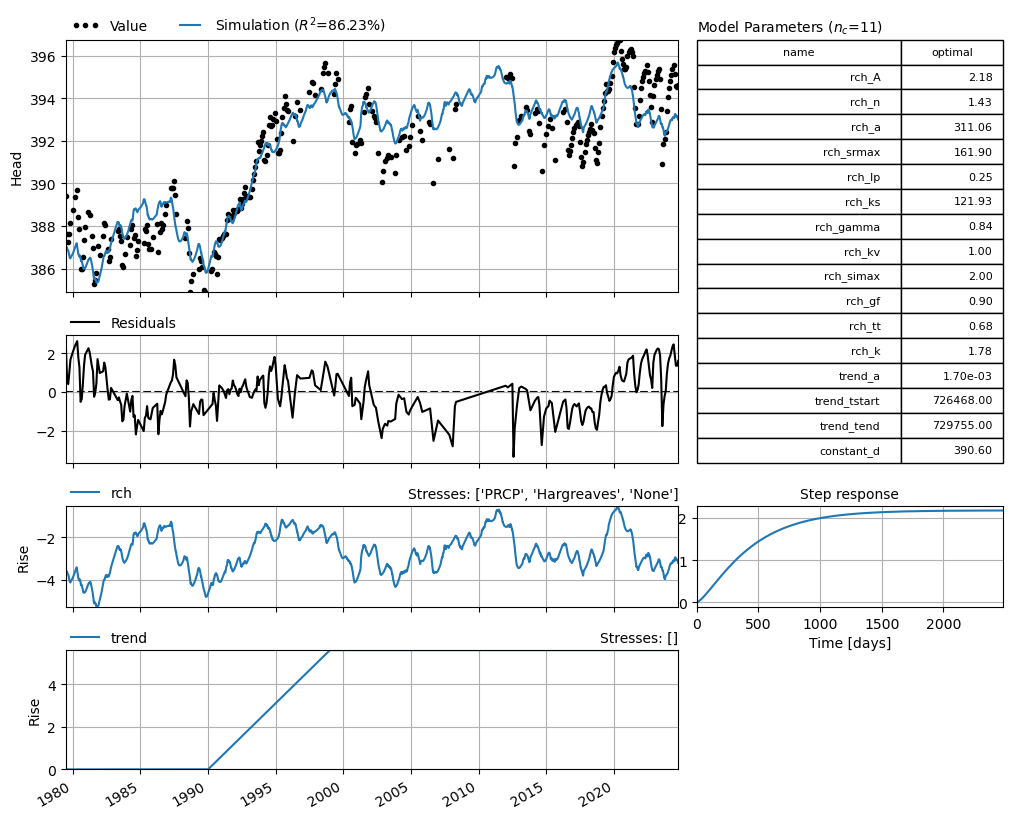

In [34]:
ml2.plots.results();

#### Only groundwater uptake

In [35]:
ml3 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, recharge=ps.rch.FlexModel(gw_uptake=True), 
                      rfunc=ps.Gamma(), name="rch", temp=Temp)
ml3.add_stressmodel(sm)

tm = ps.LinearTrend(start="1990-01-01", end="1999-01-01", name="trend")
ml3.add_stressmodel(tm)

ml3.solve()

INFO: Time Series 'Value': 206 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 7 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'None': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    69                     EVP          86.82
nobs    338                    R2            0.87
noise   False                  RMSE          1.10
tmin    1979-06-30 00:00:00    AICc         85.98
tmax    2024-09-30 00:00:00    BIC         119.84
freq    D                      Obj         206.32
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (9 optimized)
                    optimal        initial   vary
rch_A              2.645891       0.317599   True
rch_n              1.291860       1.000000   True
rch_a            402.323767      10.000000   True
rch_srmax         51.663439     250.000000   True
rch_lp             0.250000       0.250000  False
rch_ks           159.308337     100.000000   True
rch_gamma          6.688343       2.000000   True
rch_kv             1.000000       1.000000  False
rch_simax          2.000000       2.000000  False
rch_gf             0.869

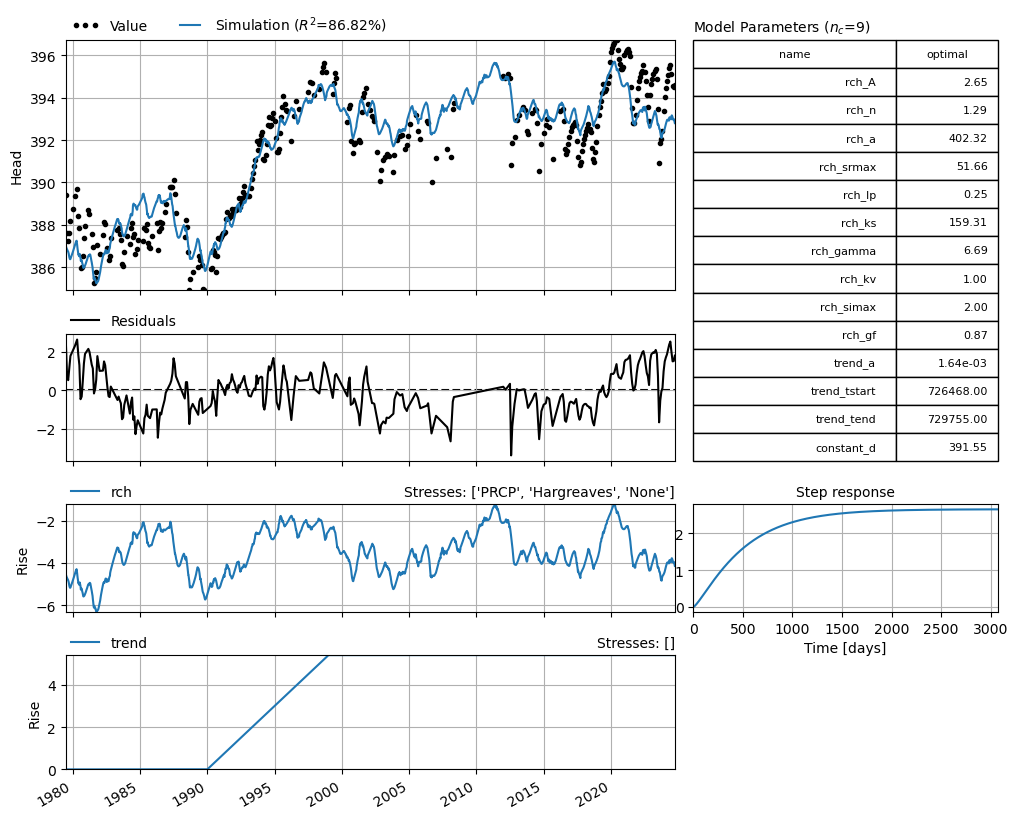

In [36]:
ml3.plots.results();

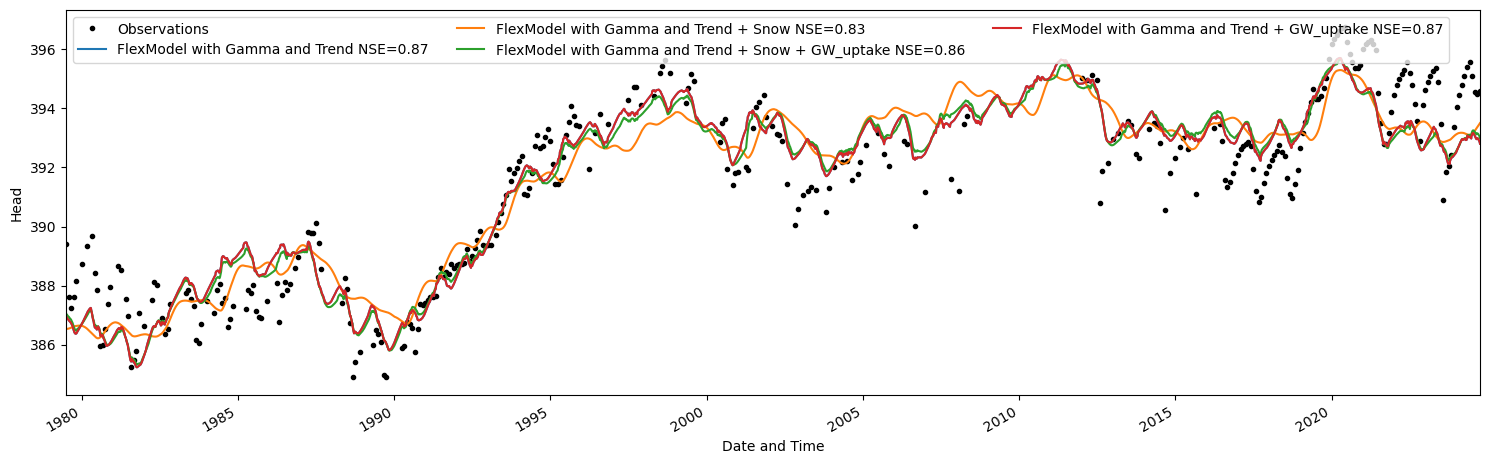

In [39]:
ax = ml.plot(figsize=(15, 5))
ml1.simulate().plot(ax=ax)
ml2.simulate().plot(ax=ax)
ml3.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "FlexModel with Gamma and Trend NSE={:.2f}".format(ml.stats.nse()),
        "FlexModel with Gamma and Trend + Snow NSE={:.2f}".format(ml1.stats.nse()),
        "FlexModel with Gamma and Trend + Snow + GW_uptake NSE={:.2f}".format(ml2.stats.nse()),
        "FlexModel with Gamma and Trend + GW_uptake NSE={:.2f}".format(ml3.stats.nse()),
    ],
    ncol=3,
)